In [45]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn as skl
import seaborn as sns

from xgboost import XGBClassifier, XGBRFRegressor
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

In [2]:
#read data and shuffle
bhbh = pd.read_csv('../Data/BHBH.csv')
bhbh = bhbh.sample(frac=1, random_state=4269)

#adding q column
bhbh['q'] = np.where(bhbh['Mass_1_out']>bhbh['Mass_0_out'],
                     bhbh['Mass_0_out']/bhbh['Mass_1_out'],
                     bhbh['Mass_1_out']/bhbh['Mass_0_out'] )
bhbh.head()

,Unnamed: 0,name,Mass_0,Z_0,spin_0,SN_0,Tstart_0,Mass_1,Z_1,a,...,Temperature_0,Mass_1_out,Semimajor,Eccentricity,GWtime,BWorldtime,RLO,CE,tdelay,q
60395,209,0_237173268166122,38.986,0.001,0.0,rapid_gauNS,zams,36.603,0.001,36900.0,...,1456.304,35.000250,38613.90000,0.469578,1.467217e+15,5.305830,NaN,NaN,1.467217e+15,0.945802
74427,314,0_619601822689455,53.812,0.010,0.0,rapid_gauNS,zams,45.722,0.010,1840.0,...,2113.531,14.892850,650.26520,0.015402,3.159041e+09,4.467546,2.0,NaN,3.159041e+09,0.847657
19596,182,0_627668720580822,62.816,0.001,0.0,rapid_gauNS,zams,44.208,0.001,9070.0,...,1184.211,41.659050,9848.93600,0.085256,6.046951e+12,4.666363,NaN,NaN,6.046951e+12,0.744376
78838,298,0_956602933765968,32.894,0.010,0.0,rapid_gauNS,zams,24.726,0.010,94.4,...,3023.349,5.982366,67.27397,0.209334,3.494275e+06,6.771645,3.0,NaN,3.494282e+06,0.696746
74567,110,0_435695643683693,76.275,0.001,0.0,rapid_gauNS,zams,60.763,0.001,1090.0,...,1474.168,35.156080,590.51490,0.025411,2.013698e+08,3.814600,2.0,NaN,2.013698e+08,0.973463


> ## Osservazione 1
> se ho pochi esempi da cui imparare, come imparo?
>
> Guarda per esempio quel bin stupido che è l'unico ad avere la q più piccola
>
> Ha senso chiedersi che xgboost o l'altro eventuale algoritmo riesca a capire come predire la label q se gli facciamo vedere solo un esempio?
>
> Questa è la conseguenza di non avere dati iid sampled per le q?


In [3]:
bhbh[bhbh['q']==bhbh['q'].min()]

,Unnamed: 0,name,Mass_0,Z_0,spin_0,SN_0,Tstart_0,Mass_1,Z_1,a,...,Temperature_0,Mass_1_out,Semimajor,Eccentricity,GWtime,BWorldtime,RLO,CE,tdelay,q
33651,95,0_714611802730091,100.138,0.0001,0.0,rapid_gauNS,zams,24.789,0.0001,17600.0,...,953.1421,5.905974,46582.54,0.797296,4.543671e+14,7.262032,NaN,NaN,4.543671e+14,0.068365


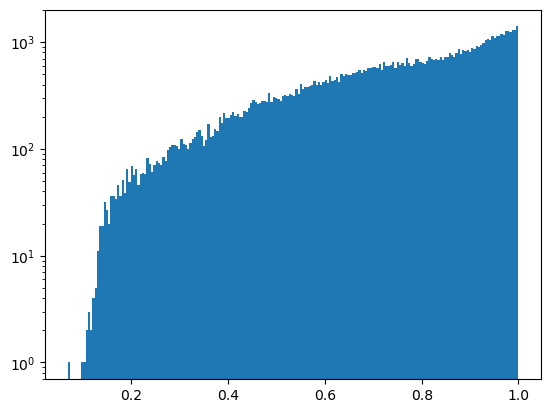

In [4]:
plt.hist(bhbh['q'], bins=200, log=True);

> ## Possibile risoluzione 1
>
> Semplicemente prendo in considerazione tutti e soli i sistemi che hanno una q con "numerosi esempi" affinchè xgboost impari
>
>

> ## Possibile risoluzione 2
>
> Prendere bin più grossi affinchè quello singolo venga in qualche modo integrato con altri
>
>

In [5]:
bhbh_filtered=bhbh[bhbh['q']>0.4]

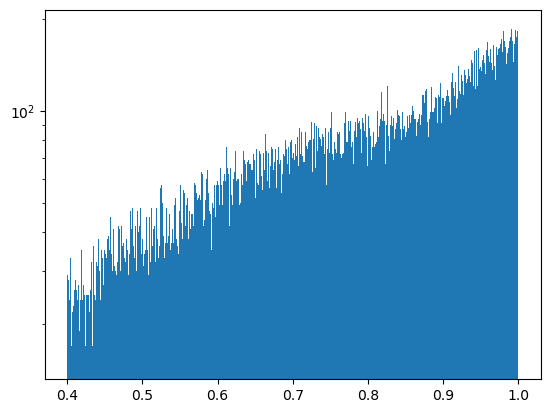

In [6]:
plt.hist(bhbh_filtered['q'], bins=1000, log=True);

In [7]:
bhbh_2=bhbh_filtered.copy()

In [8]:
n_bins=200
lin=np.linspace(bhbh_filtered['q'].min(), bhbh_filtered['q'].max(), num=n_bins)
bhbh_2['label']=np.digitize( bhbh_filtered['q'], lin, right=True)

## Sanity checks on the splitting/binning

In [9]:
np.digitize( bhbh_filtered['q'].min(), lin, right=True), np.digitize( bhbh_filtered['q'].max(), lin, right=True)

(0, 199)

In [10]:
# check if they are all consecutive
np.unique(bhbh_2['label'])==np.arange(0, 200)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [11]:
xgbc = XGBClassifier()
# print(xgbc)
XGBClassifier(booster='gbtree',
#               colsample_bylevel=1,
#               colsample_bynode=1,
#               colsample_bytree=1,
#               gamma=0,
              learning_rate=0.3,
#               max_delta_step=0,
              max_depth=3,
#               min_child_weight=1,
#               missing=None,
              n_estimators=10,
              n_jobs=1,
              nthread=None,
              objective='multi:softprob',
              random_state=0,
              reg_alpha=0,
              reg_lambda=1,
              scale_pos_weight=1,
              seed=1234,
              silent=None,
              subsample=1,
              verbosity=1) 

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=1, nthread=None, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [15]:
perc=0.3
m_train=int(bhbh_2.shape[0]*perc)
m_train=10000

In [16]:
x_train=bhbh_2[['Mass_0', 'Z_0', 'Mass_1', 'Z_1', 'a', 'e']][:m_train]
x_test=bhbh_2[['Mass_0', 'Z_0', 'Mass_1', 'Z_1', 'a', 'e']][m_train:]

y_train=bhbh_2['label'][:m_train]
y_test=bhbh_2['label'][m_train:]

/tmp/ipykernel_562/882524820.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train=bhbh_2['label'][:m_train]
/tmp/ipykernel_562/882524820.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_test=bhbh_2['label'][m_train:]


In [17]:

xgbc.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [30]:
scores = cross_val_score(xgbc, x_train,y_train, cv=3)
print("Mean cross-validation score: %.2f" % scores.mean())

/home/tom/anaconda3/envs/lcp/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Mean cross-validation score: nan


/home/tom/anaconda3/envs/lcp/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tom/anaconda3/envs/lcp/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tom/anaconda3/envs/lcp/lib/python3.10/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/home/tom/anaconda3/envs/lcp/lib/python3.10/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid class

In [21]:
y_pred = xgbc.predict(x_test)
cm = confusion_matrix(y_test,y_pred) 
print(cm)

[[ 1  0  2 ...  0  1  0]
 [ 2  9  1 ...  0  0  0]
 [ 1  2  1 ...  0  0  2]
 ...
 [ 0  0  0 ... 52 43 49]
 [ 0  0  0 ... 49 68 44]
 [ 0  0  0 ... 37 42 90]]


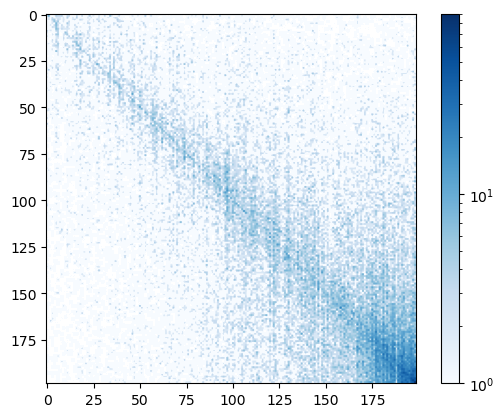

In [29]:
plt.imshow(cm, cmap='Blues', norm='log')
plt.colorbar();

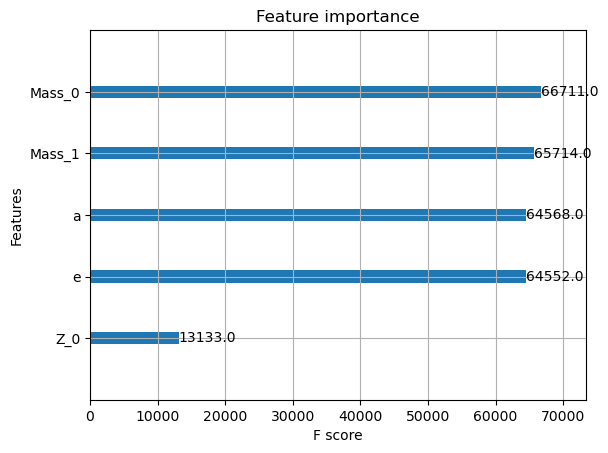

In [32]:
from xgboost import plot_importance
plot_importance(xgbc) 
plt.show()

In [35]:
bhbh['q_0'] = np.where(bhbh['Mass_1']>bhbh['Mass_0'],
                     bhbh['Mass_0']/bhbh['Mass_1'],
                     bhbh['Mass_1']/bhbh['Mass_0'] )

In [36]:
np.corrcoef(bhbh['q_0'], bhbh['q'])

array([[1.        , 0.50053963],
       [0.50053963, 1.        ]])

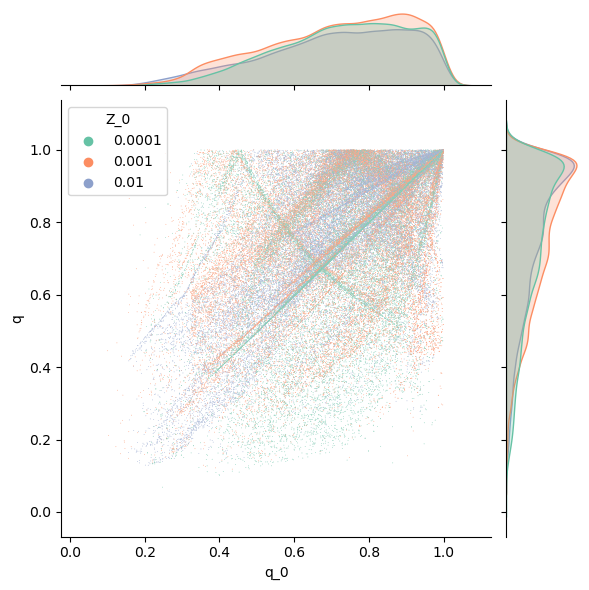

In [58]:
sns.jointplot(x=bhbh['q_0'], y=bhbh['q'], hue=bhbh['Z_0'], palette="Set2", s=0.3);